# Lecture 0: Paths, betweenness and centrality metrics 

In [1]:
import numpy as np

## The centrality of the Medici's Family
![cacca](../Images/ff_network.png)
One of the main results regarding the Florentine Families network is the fact that the Medici family were extremely central. Let's load again our edge list and make some calculation...

### Load the data

#### Load data

In [2]:
ff_am=np.genfromtxt('../Data/florentine_families.dat', skip_header=41, dtype='i8')[:16]

In [3]:
ff_fam=np.genfromtxt('../Data/florentine_families.dat', skip_header=4, skip_footer=53, dtype='U50')

In [4]:
aux=ff_am[ff_fam!='PUCCI'].T
ff_am=aux[ff_fam!='PUCCI']

In [5]:
ff_am.shape

(15, 15)

In [6]:
np.sum(ff_am, axis=0)

array([1, 3, 2, 3, 3, 1, 4, 1, 6, 1, 3, 3, 2, 4, 3])

In [7]:
np.all(ff_am.T==ff_am)

True

In [8]:
ff_fam=ff_fam[ff_fam!='PUCCI']

In [9]:
l_ff=len(ff_fam)
l_ff

15

#### Convert it to adjacency list

In [10]:
np.where(ff_am[0]==1)[0]

array([8])

In [11]:
ff_adl=[]
for i_ffam, f in enumerate(ff_am):
    ff_adl.append(np.where(f==1)[0])

In [12]:
ff_adl

[array([8]),
 array([5, 6, 8]),
 array([4, 8]),
 array([ 6, 10, 13]),
 array([ 2, 10, 13]),
 array([1]),
 array([ 1,  3,  7, 14]),
 array([6]),
 array([ 0,  1,  2, 11, 12, 14]),
 array([12]),
 array([ 3,  4, 13]),
 array([ 8, 13, 14]),
 array([8, 9]),
 array([ 3,  4, 10, 11]),
 array([ 6,  8, 11])]

### Breadth-first algorithm for distances

In [33]:
source=np.random.randint(l_ff)

In [34]:
ff_fam[source]

'GUADAGNI'

In [22]:
distance=-1*np.ones(l_ff, dtype='i8')
# negatives values are easy to find and for sure are a wrongly defined distance
d=0
distance[source]=d
print(ff_fam[source])

ACCIAIUOL


In [23]:
# get the nearest neighbours
nn=ff_adl[source]
nn

array([8])

In [24]:
ff_fam[nn]

array(['MEDICI'], dtype='<U50')

In [25]:
d+=1
# add 1 to the distance and assign the new distance to the nn
distance[nn]=d

In [26]:
distance

array([ 0, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1])

In [28]:
d+=1
for i_n, n in enumerate(nn):
    aux=ff_adl[n]
    aux=aux[distance[aux]==-1]
    # get the nn of the nn for which we do not have already calculated the distance
    distance[aux]=d
    if i_n==0:
        new_nn=aux
    else:
        new_nn=np.concatenate((new_nn, aux))

In [29]:
distance

array([ 0,  2,  2, -1, -1, -1, -1, -1,  1, -1, -1,  2,  2, -1,  2])

In [30]:
np.vstack((ff_fam, distance)).T

array([['ACCIAIUOL', '0'],
       ['ALBIZZI', '2'],
       ['BARBADORI', '2'],
       ['BISCHERI', '-1'],
       ['CASTELLAN', '-1'],
       ['GINORI', '-1'],
       ['GUADAGNI', '-1'],
       ['LAMBERTES', '-1'],
       ['MEDICI', '1'],
       ['PAZZI', '-1'],
       ['PERUZZI', '-1'],
       ['RIDOLFI', '2'],
       ['SALVIATI', '2'],
       ['STROZZI', '-1'],
       ['TORNABUON', '2']], dtype='<U50')

In [31]:
nn=new_nn
d+=1
for i_n, n in enumerate(nn):
    aux=ff_adl[n]
    aux=aux[distance[aux]==-1]
    distance[aux]=d
    if i_n==0:
        new_nn=aux
    else:
        new_nn=np.concatenate((new_nn, aux))

In [32]:
np.vstack((ff_fam, distance)).T

array([['ACCIAIUOL', '0'],
       ['ALBIZZI', '2'],
       ['BARBADORI', '2'],
       ['BISCHERI', '-1'],
       ['CASTELLAN', '-1'],
       ['GINORI', '-1'],
       ['GUADAGNI', '-1'],
       ['LAMBERTES', '-1'],
       ['MEDICI', '1'],
       ['PAZZI', '-1'],
       ['PERUZZI', '-1'],
       ['RIDOLFI', '2'],
       ['SALVIATI', '2'],
       ['STROZZI', '-1'],
       ['TORNABUON', '2']], dtype='<U50')

... and so on...

### Exercise: build your own function calculating the distances from a given node (input of the function)

Suppose we are starting with the node "source".
1. assign distance=0 to source (since it is at distance 0 from itself);
2. for any vertex $i$ whose distance is $d$, look for its neighbors. For any $j$ in the neighbors:
    a. if $d[j]$ has not been assigned yet, then $d[j]=d[i]+1$.

In [35]:
def bf_dist(source, adl):
    _adl=adl
    ll=len(_adl)
    distance=-1*np.ones(ll, dtype='i8')
    d=0
    distance[source]=d
    _source=np.array([source])
    while len(np.where(distance==-1)[0])>0:
        d+=1
        for i_n, n in enumerate(_source):
            aux=_adl[n]
            aux=aux[distance[aux]==-1]
            distance[aux]=d
            if i_n==0:
                new_source=aux
            else:
                new_source=np.concatenate((new_source, aux))
        _source=new_source
    return distance

In [36]:
%timeit bf_dist(source, ff_adl)

172 µs ± 2.62 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


##### M.E.J. Newman solution

An effective implementation of this algorithm, as proposed by M.E.J. Newman in his book, can be obtained by using a queue, i.e. a _first-in/first-out_ buffer.
![](../Images/l0_queue.png)

Let us start filling the queue with the source node. We are going to use two pointers, one pointing at the beginning (the reading pointer), one at the end (the writing one). 
It works as follows:
1. place the label of the source vertex in the first element of the queue and set the pointer "read_p" to it. 
2. place the writing pointer "write_p" in the position following "read_p";
3. define a distance array;
4. set the distance array entry for the source to zero. 
5. if read_p==write_p, the algorithm is finished. Otherwise, read the element pointed by "read_p" (*new source*) and increase the value of "read_p" by one;
6. set d (auxiliary variable) equal to the value of the distance of the *new source*;
7. for each of the neighbours of *new source*, check if it has been already assigned a value in the distance array. If not:
    a.) set its distance from the source (in the distance array) to d+1;
    b.) add it to the queue in the position "write_p";
    c.) add 1 to the value of "write_p";
8. repeat from 5.

In [37]:
def MEJ_bf_dist(source, adl):
    _adl=adl
    ll=len(_adl)
    _distance=-1*np.ones(ll, dtype='i8')
    d=0
    _distance[source]=d
    queue=np.zeros(ll, dtype='i8')
    read_p=0
    write_p=1
    queue[read_p]=source
    l_nn=ll
    while read_p!=write_p:
        _source=queue[read_p]
        _d=_distance[_source]
        _nn=_adl[_source]
        _nn=_nn[_distance[_nn]==-1]
        _distance[_nn]=_d+1
        l_nn=len(_nn)
        queue[write_p:write_p+l_nn]=_nn
        write_p=write_p+l_nn
        read_p+=1
    return _distance

In [38]:
MEJ_bf_dist(source, ff_adl)==bf_dist(source, ff_adl)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [39]:
np.all(MEJ_bf_dist(source, ff_adl)==bf_dist(source, ff_adl))

True

In [40]:
%timeit bf_dist(source, ff_adl)

183 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [41]:
%timeit MEJ_bf_dist(source, ff_adl)

133 µs ± 5.38 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Actually, we can complicate the routine in order to calculate the number of shortest paths connecting the source with any other node in the network

Suppose we are starting with the node "source".
1. assign distance=0 to source (since it is at distance 0 from itself);
2. assign weight=1 to source (it will be clear what is the sense of those weights);
3. for any vertex $i$ whose distance is $d$, look for its neighbors. For any $j$ in the neighbors:
    a. if $d[j]$ has not been assigned yet, then $d[j]=d[i]+1$ and $w[j]=w[i]$;
    b. if $d[j]$ has been already assigned AND $d[j]=d[i]+1$, then $w[j]+=w[i]$;

In [42]:
def MEJ_bf_dist_w(source, adl):
    _adl=adl
    ll=len(_adl)
    _distance=-1*np.ones(ll, dtype='i8')
    _weights=np.zeros(ll, dtype='i8')
    d=0
    _distance[source]=d
    _weights[source]=1
    queue=np.zeros(ll, dtype='i8')
    read_p=0
    write_p=1
    queue[read_p]=source
    l_nn=ll
    while read_p!=write_p:
        _source=queue[read_p]
        _d=_distance[_source]
        _w=_weights[_source]
        
        _nn=_adl[_source]
        # using numpy
        new_nn=_nn[_distance[_nn]==-1]
        old_nn=_nn[_distance[_nn]==_d+1]
        
        _distance[new_nn]=_d+1
        _weights[new_nn]=_w
        
        _weights[old_nn]+=_w
        
        l_nn=len(new_nn)
        queue[write_p:write_p+l_nn]=new_nn
        write_p=write_p+l_nn
        # still the same from here
        
        read_p+=1
    return _distance, _weights

In [43]:
dist, wei=MEJ_bf_dist_w(source, ff_adl)

In [45]:
def MEJ_bf_dist_w_2(source, adl):
    _adl=adl
    ll=len(_adl)
    _distance=-1*np.ones(ll, dtype='i8')
    _weights=np.zeros(ll, dtype='i8')
    d=0
    _distance[source]=d
    _weights[source]=1
    queue=np.zeros(ll, dtype='i8')
    read_c=0
    write_c=1
    queue[read_c]=source
    l_nn=ll
    while read_c!=write_c:
        _source=queue[read_c]
        _d=_distance[_source]
        _w=_weights[_source]
        
        _nn=_adl[_source]
        # using python
        for n in _nn:
            if _distance[n]==-1:
                _distance[n]=_d+1
                _weights[n]=_w
                queue[write_c]=n
                write_c+=1
            elif _distance[n]==_d+1: 
                _weights[n]+=_w
        # still the same from here
                
        read_c+=1
    return _distance, _weights

In [46]:
np.all(MEJ_bf_dist_w(source, ff_adl)[0]==MEJ_bf_dist_w_2(source, ff_adl)[0])

True

In [47]:
np.all(MEJ_bf_dist_w(source, ff_adl)[1]==MEJ_bf_dist_w_2(source, ff_adl)[1])

True

In [48]:
%timeit MEJ_bf_dist_w_2(source, ff_adl)

99.9 µs ± 82.8 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [49]:
%timeit MEJ_bf_dist_w(source, ff_adl)

315 µs ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [50]:
np.vstack((ff_fam, dist)).T

array([['ACCIAIUOL', '3'],
       ['ALBIZZI', '1'],
       ['BARBADORI', '3'],
       ['BISCHERI', '1'],
       ['CASTELLAN', '3'],
       ['GINORI', '2'],
       ['GUADAGNI', '0'],
       ['LAMBERTES', '1'],
       ['MEDICI', '2'],
       ['PAZZI', '4'],
       ['PERUZZI', '2'],
       ['RIDOLFI', '2'],
       ['SALVIATI', '3'],
       ['STROZZI', '2'],
       ['TORNABUON', '1']], dtype='<U50')

In [51]:
np.vstack((ff_fam, wei)).T

array([['ACCIAIUOL', '2'],
       ['ALBIZZI', '1'],
       ['BARBADORI', '2'],
       ['BISCHERI', '1'],
       ['CASTELLAN', '2'],
       ['GINORI', '1'],
       ['GUADAGNI', '1'],
       ['LAMBERTES', '1'],
       ['MEDICI', '2'],
       ['PAZZI', '2'],
       ['PERUZZI', '1'],
       ['RIDOLFI', '1'],
       ['SALVIATI', '2'],
       ['STROZZI', '1'],
       ['TORNABUON', '1']], dtype='<U50')

![cacca](../Images/ff_network.png)

### The node betweenness

In [52]:
# create a dictionary of dictionary (slightly more efficient than a matrix)
ddd={}
www={}
for fff in range(l_ff):
    cacca=MEJ_bf_dist_w_2(fff, ff_adl)
    ddd[fff]=cacca[0]
    www[fff]=cacca[1]

In [53]:
nb=np.zeros(l_ff)

In [55]:
for fff in range(l_ff):
    dist_f=ddd[fff]
    weig_f=www[fff]
    # these are the distance and number of shortests path dictionaries for the node fff
    for source in range(l_ff-1):
        if source!=fff:
            dist_s=ddd[source]
            weig_s=www[source]
            #for any other node in the network, define the same dictionaries.
            # the source is going to be one of the endpoints of the shortest path
            # for the calculation of the betweenness of fff 
            for target in range(source+1, l_ff):
                # this is needed in order to avoid considering twice the same couple
                if target!=fff:
                    if dist_s[fff]+dist_f[target]==dist_s[target]:
                        # fff is a node in the shortest path between source and target
                        sp_through_fff=weig_f[source]*weig_f[target]
                        nb[fff]+=sp_through_fff/weig_s[target]

![cacca](../Images/ff_network.png)

In [56]:
def node_betweenness(_adl, _ll):
# create a dictionary of dictionary (slightly more efficient than a matrix)
    ddd={}
    www={}
    for fff in range(_ll):
        cacca=MEJ_bf_dist_w_2(fff, _adl)
        ddd[fff]=cacca[0]
        www[fff]=cacca[1]

    nb=np.zeros(_ll)

    for fff in range(_ll):
        dist_f=ddd[fff]
        weig_f=www[fff]
        for source in range(_ll-1):
            if source!=fff:
                dist_s=ddd[source]
                weig_s=www[source]
                for target in range(source+1, _ll):
                    if target!=fff:
                        if dist_s[fff]+dist_f[target]==dist_s[target]:
                            #print(ff_fam[source], ff_fam[fff],  ff_fam[target], weig_f[source]*weig_f[target]/weig_s[target],weig_f[source],weig_f[target],weig_s[target])
                            nb[fff]+=weig_f[source]*weig_f[target]/weig_s[target]
    return nb

In [57]:
np.all(node_betweenness(ff_adl, l_ff)==nb)

False

In [58]:
%timeit node_betweenness(ff_adl, l_ff)

2.96 ms ± 630 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


### The wheel

Actually, NetworkX already calculates it efficiently, aka do not reinvent the wheel!
![](../Images/l0_wheel.jpeg)

In [59]:
import networkx as nx

In [60]:
where_0=np.where(ff_am==1)
who=np.vstack((where_0[0], where_0[1])).T
edges=[]
for w in who:
    if w[0]<w[1]:
        edges.append((ff_fam[w[0]],ff_fam[w[1]]))

In [61]:
G=nx.Graph()

In [62]:
G.add_edges_from(edges)

In [63]:
bet=nx.betweenness_centrality(G, normalized=False)

In [64]:
bet

{'ACCIAIUOL': 0.0,
 'ALBIZZI': 19.333333333333336,
 'BARBADORI': 8.5,
 'BISCHERI': 9.5,
 'CASTELLAN': 5.0,
 'GINORI': 0.0,
 'GUADAGNI': 23.166666666666664,
 'LAMBERTES': 0.0,
 'MEDICI': 47.5,
 'PAZZI': 0.0,
 'PERUZZI': 2.0,
 'RIDOLFI': 10.333333333333332,
 'SALVIATI': 13.0,
 'STROZZI': 9.333333333333334,
 'TORNABUON': 8.333333333333334}

In [65]:
[abs(bet[ff_fam[i]]-nb[i]) for i in range(l_ff)]

[0.0,
 19.33333333333332,
 8.5,
 9.5,
 5.0,
 0.0,
 23.166666666666664,
 0.0,
 47.5,
 0.0,
 2.0,
 10.33333333333334,
 13.0,
 9.333333333333337,
 8.333333333333337]

In [66]:
%timeit nx.betweenness_centrality(G, normalized=False)

1.28 ms ± 589 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [67]:
%timeit node_betweenness(ff_adl, l_ff)

3 ms ± 1.13 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Losing by something more than a factor of 2 is not that bad...

#### Something more from NetworkX for plots

In [68]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
bc_norm=nx.betweenness_centrality(G, normalized=True)

In [70]:
bc_norm

{'ACCIAIUOL': 0.0,
 'ALBIZZI': 0.2124542124542125,
 'BARBADORI': 0.09340659340659341,
 'BISCHERI': 0.1043956043956044,
 'CASTELLAN': 0.05494505494505495,
 'GINORI': 0.0,
 'GUADAGNI': 0.25457875457875456,
 'LAMBERTES': 0.0,
 'MEDICI': 0.521978021978022,
 'PAZZI': 0.0,
 'PERUZZI': 0.02197802197802198,
 'RIDOLFI': 0.11355311355311355,
 'SALVIATI': 0.14285714285714288,
 'STROZZI': 0.10256410256410257,
 'TORNABUON': 0.09157509157509158}

Let us color the nodes according to their node betweenness! As you remember there were the official colors...
![](../Images/l3_matplotlib_colors.webp)
... and even the color maps...
![](../Images/l0_colormap_00.png)
... of different types! 
![](../Images/l0_colormap_01.png)
[Click here for the whole list](https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html)

In [71]:
def red_me(color):
    return cm.get_cmap('YlOrRd')(color)

In [72]:
def plasma_me(color):
    return cm.get_cmap('plasma')(color)

In [73]:
pos=nx.kamada_kawai_layout(G)

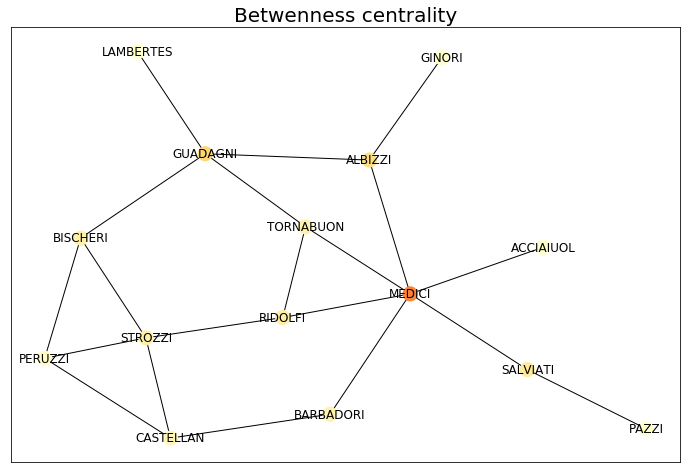

In [74]:
plt.figure(figsize=(12, 8))
plt.title('Betwenness centrality', fontsize=20)
nx.draw_networkx_edges(G, pos)
rgb=[red_me(bc_norm[n]) for n in list(G.nodes)]
nx.draw_networkx_nodes(G, pos, list(G.nodes), node_size = 200, node_color =rgb)
nx.draw_networkx_labels(G, pos)
plt.show()

Actually, other centrality measures are present...

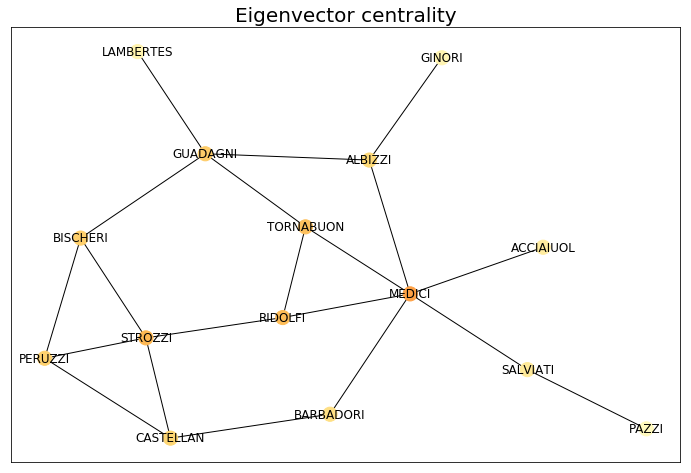

In [75]:
ec_norm=nx.eigenvector_centrality(G)
plt.figure(figsize=(12, 8))
plt.title('Eigenvector centrality', fontsize=20)
nx.draw_networkx_edges(G, pos)
rgb=[red_me(ec_norm[n]) for n in list(G.nodes)]
nx.draw_networkx_nodes(G, pos, list(G.nodes), node_size = 200, node_color =rgb)
nx.draw_networkx_labels(G, pos)
plt.show()

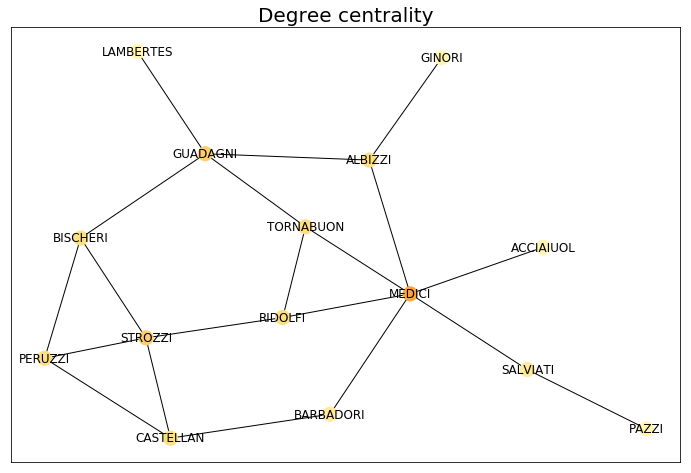

In [76]:
dc_norm=nx.degree_centrality(G)
plt.figure(figsize=(12, 8))
plt.title('Degree centrality', fontsize=20)
nx.draw_networkx_edges(G, pos)
rgb=[red_me(dc_norm[n]) for n in list(G.nodes)]
nx.draw_networkx_nodes(G, pos, list(G.nodes), node_size = 200, node_color =rgb)
nx.draw_networkx_labels(G, pos)
plt.show()

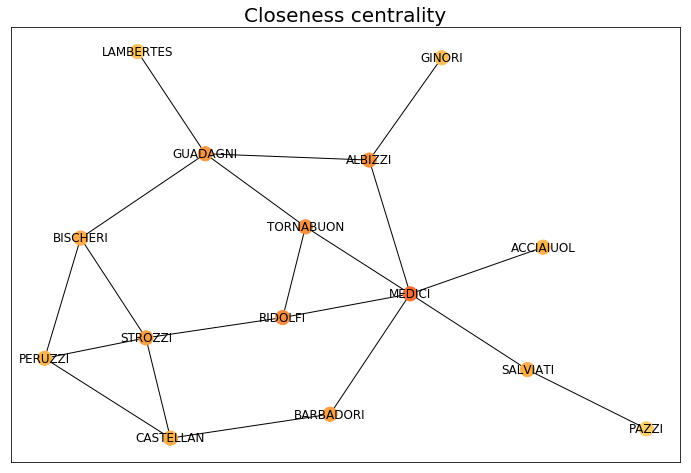

In [77]:
cc_norm=nx.closeness_centrality(G)
plt.figure(figsize=(12, 8))
plt.title('Closeness centrality', fontsize=20)
nx.draw_networkx_edges(G, pos)
rgb=[red_me(cc_norm[n]) for n in list(G.nodes)]
nx.draw_networkx_nodes(G, pos, list(G.nodes), node_size = 200, node_color =rgb)
nx.draw_networkx_labels(G, pos)
plt.show()

Actually, it is a mess to see all the plots, one by one...

In [78]:
titles=['Degree centrality', 'Eigenvector centrality', 'Betwenness centrality', 'Closeness centrality']

In [79]:
def centralities(G, n):
    if n==0:
        return nx.degree_centrality(G)
    elif n==1:
        return nx.eigenvector_centrality(G)
    elif n==2:
        return nx.betweenness_centrality(G, normalized=True)
    else:
        return nx.closeness_centrality(G)

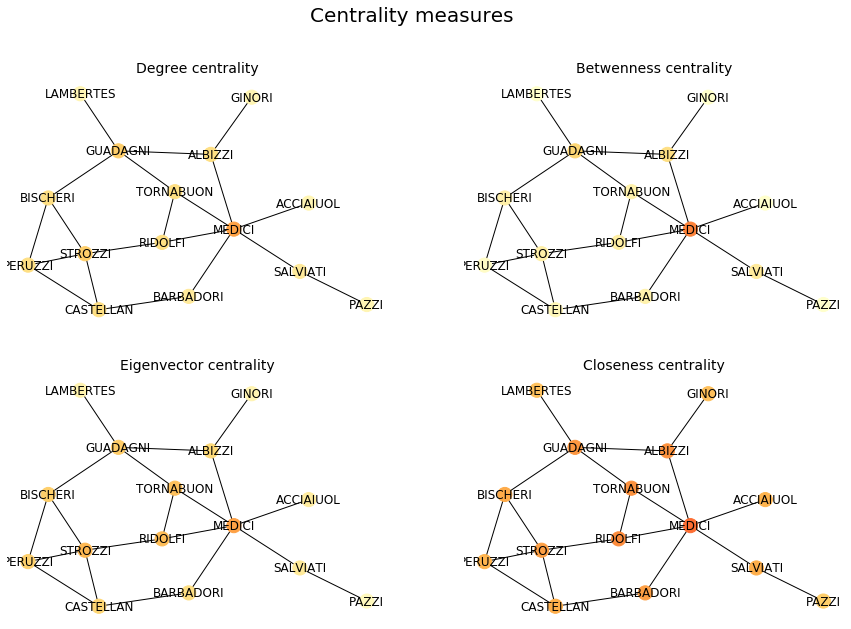

In [80]:
pos=nx.kamada_kawai_layout(G)
#plt.figure(figsize=(10, 10))
fig, ax_lst = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle('Centrality measures', fontsize=20)
# cancel the frame
for t in enumerate(titles):
    x=t[0]%2
    y=t[0]//2
    ax_lst[x,y].set_title(t[1], fontsize=14)
    nx.draw_networkx_edges(G, pos, ax=ax_lst[x, y])
    centrality=centralities(G, t[0])
    rgb=[red_me(centrality[n]) for n in list(G.nodes)]
    nx.draw_networkx_nodes(G, pos, list(G.nodes), node_size = 200, node_color =rgb, ax=ax_lst[x, y])
    nx.draw_networkx_labels(G, pos, ax=ax_lst[x, y])
    ax_lst[x, y].axis('off')
    # cancel the frame
plt.show()

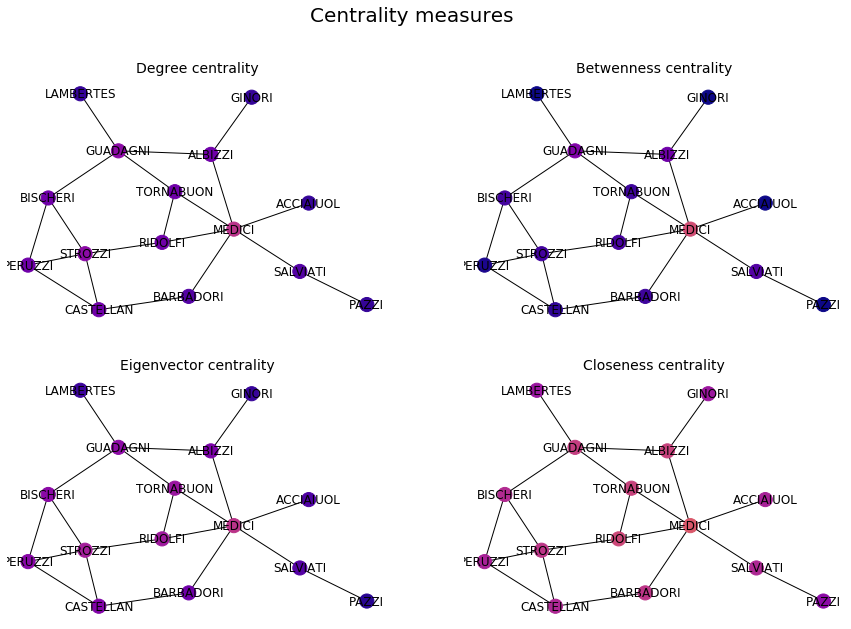

In [81]:
pos=nx.kamada_kawai_layout(G)
#plt.figure(figsize=(10, 10))
fig, ax_lst = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle('Centrality measures', fontsize=20)
# cancel the frame
for t in enumerate(titles):
    x=t[0]%2
    y=t[0]//2
    ax_lst[x,y].set_title(t[1], fontsize=14)
    nx.draw_networkx_edges(G, pos, ax=ax_lst[x, y])
    centrality=centralities(G, t[0])
    rgb=[plasma_me(centrality[n]) for n in list(G.nodes)]
    nx.draw_networkx_nodes(G, pos, list(G.nodes), node_size = 200, node_color =rgb, ax=ax_lst[x, y])
    nx.draw_networkx_labels(G, pos, ax=ax_lst[x, y])
    ax_lst[x, y].axis('off')
    # cancel the frame
plt.show()

### Exercise: make the same plots with the Zakary Karate Club